#  Criação e modelagem de machine learning

#### Fazer importações

In [1]:
# Imports
import pandas as pd
from sklearn.utils import shuffle
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import joblib
import unidecode
from string import punctuation
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix 
import seaborn as sn
import numpy as np 
import matplotlib.pyplot as plt
import pickle

# inicializa o nlp do spacy
nlp = spacy.load("pt_core_news_sm")

#### Leitura da base em JSON

In [2]:
# Ler arquivo Json - arquivo usando com orient=records
data = pd.read_json('definedcommentsdf.json')

# Cria um dataframe so para os valores das colunas toxico e comentario
comments_toxico = data.drop(['link','datahora'], axis=1)
comments_toxico.head()

,idcomentario,toxico,comentario,tipo
0,5e52b6f032766bbb6d01c5cc,False,Passando o pacote anti crime na camara e sena...,
1,5e52b83c32766bbb6d01d2c0,False,nossa ai fica dificil...antes sobia 20 reais ...,
2,5e52b83c32766bbb6d01d1e2,False,Até quando ele vai comparar tudo a um casamen...,
3,5e52b84f32766bbb6d01db26,False,99 nunca mais! Usei o 99 para pagar com cartã...,
4,5e52b84f32766bbb6d01d883,False,Já foi confirmado pela UFBA que é óleo venezu...,


## Aqui começa o tratamento da base

In [3]:
# Modifica valores false/true para 0,1
comments_toxico.loc[(comments_toxico.toxico == True),'toxico'] = 1
comments_toxico.loc[(comments_toxico.toxico == False),'toxico'] = 0

In [4]:
# DataFrame com toxicos e não toxicos
toxic_data = comments_toxico[comments_toxico.toxico == 1]
nontoxic_data = comments_toxico[comments_toxico.toxico == 0]

In [5]:
# Conta quantidade de cada classificacao
count_toxic = toxic_data.shape[0]
count_nontoxic = nontoxic_data.shape[0]

# Checa a quantidade de cada dataset e deixa 50%/50% de cada classificacao 
if count_nontoxic > count_toxic:
    nontoxic_data = nontoxic_data.sample(count_toxic, replace=True)
    
if count_toxic > count_nontoxic:
    toxic_data = toxic_data.sample(count_nontoxic, replace=True)
    
# Ignora Warnings de indexação
pd.options.mode.chained_assignment = None

# Cria contagem de idcomentarios iguais
nontoxic_data['amount_idcomentario']= nontoxic_data.idcomentario.map(nontoxic_data.idcomentario.value_counts())
toxic_data['amount_idcomentario']= toxic_data.idcomentario.map(toxic_data.idcomentario.value_counts())

# Criar listas de apoio
data_bigtoxic = [] 
data_bignontoxic = []
dataigual = []
for row in nontoxic_data.itertuples():
    for row1 in toxic_data.itertuples():
        if row1.idcomentario == row.idcomentario and row1.amount_idcomentario > row.amount_idcomentario:
            data_bigtoxic.append(row1)
        elif row1.idcomentario == row.idcomentario and row1.amount_idcomentario < row.amount_idcomentario:
            data_bignontoxic.append(row)
        elif row1.idcomentario == row.idcomentario and row1.amount_idcomentario == row.amount_idcomentario:
            dataigual.append(row1.idcomentario)
            

In [6]:
# Recria dataframe com samples de toxic e non toxic, resetando index 
mergedata = [nontoxic_data,toxic_data]
new_dataframe = pd.concat(mergedata)
new_dataframe.reset_index(drop=True, inplace=True)

In [7]:
# Remove comentarios que tem mesmo valor de toxico e nao toxico
data_framefinal = new_dataframe[~new_dataframe.idcomentario.isin(dataigual)]

In [8]:
# DataFrame axuliar para criar tokens do nlp do spacy
comentarios_df = data_framefinal.drop(['idcomentario','tipo','amount_idcomentario'], axis=1)
comentarios_df = comentarios_df.drop_duplicates(subset=['toxico', 'comentario'], keep='first') # remove itens duplicados
comentarios_df

,toxico,comentario
0,0,kkkkkkkk\n
1,0,Não faz sentido isso que o porteiro disse uma...
2,0,O NOME DISSO É USO DA MÁQUINA PÚBLICA PARA BE...
3,0,"Oliveira, não é só pq não é militar que não t..."
4,0,Alarmada*
...,...,...
1566,1,Cara chato !
1567,1,Fala M não vai...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão..."


## Aqui começa o pré-processamento

#### Cada pré-processamento foi separado em uma coluna do DataFrame de forma a treinar a ML individualmente para cada coluna do DataFrame

In [9]:
comentarios_df = comentarios_df.replace(r'\n', ' ', regex=True) 
comentarios_df

,toxico,comentario
0,0,kkkkkkkk
1,0,Não faz sentido isso que o porteiro disse uma...
2,0,O NOME DISSO É USO DA MÁQUINA PÚBLICA PARA BE...
3,0,"Oliveira, não é só pq não é militar que não t..."
4,0,Alarmada*
...,...,...
1566,1,Cara chato !
1567,1,Fala M não vai...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão..."


In [10]:
# Transforma todas as letras em minusculo
minusculo = []
for comentario in comentarios_df['comentario']:
    minusculo.append(comentario.lower())
    
comentarios_df['minusculo'] = minusculo

comentarios_df

,toxico,comentario,minusculo
0,0,kkkkkkkk,kkkkkkkk
1,0,Não faz sentido isso que o porteiro disse uma...,não faz sentido isso que o porteiro disse uma...
2,0,O NOME DISSO É USO DA MÁQUINA PÚBLICA PARA BE...,o nome disso é uso da máquina pública para be...
3,0,"Oliveira, não é só pq não é militar que não t...","oliveira, não é só pq não é militar que não t..."
4,0,Alarmada*,alarmada*
...,...,...,...
1566,1,Cara chato !,cara chato !
1567,1,Fala M não vai...,fala m não vai...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão...","boisotrooper, a giobo de.ve mais de um biihão..."


In [11]:
# Remove espaços em brancos das strings
comentarios_df['whitespacesnone'] = [comentario.strip() for comentario in comentarios_df['minusculo']] # unidecode

comentarios_df

,toxico,comentario,minusculo,whitespacesnone
0,0,kkkkkkkk,kkkkkkkk,kkkkkkkk
1,0,Não faz sentido isso que o porteiro disse uma...,não faz sentido isso que o porteiro disse uma...,não faz sentido isso que o porteiro disse uma ...
2,0,O NOME DISSO É USO DA MÁQUINA PÚBLICA PARA BE...,o nome disso é uso da máquina pública para be...,o nome disso é uso da máquina pública para ben...
3,0,"Oliveira, não é só pq não é militar que não t...","oliveira, não é só pq não é militar que não t...","oliveira, não é só pq não é militar que não te..."
4,0,Alarmada*,alarmada*,alarmada*
...,...,...,...,...
1566,1,Cara chato !,cara chato !,cara chato !
1567,1,Fala M não vai...,fala m não vai...,fala m não vai...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!!...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão...","boisotrooper, a giobo de.ve mais de um biihão...","boisotrooper, a giobo de.ve mais de um biihão ..."


In [12]:
# Remove acentuação
comentarios_df['unidecode'] = [unidecode.unidecode(comentario) for comentario in comentarios_df['whitespacesnone']]

In [13]:
# Remove pontuação, stopwords, números soltos e gera os tokens SEM UNIDECODE
pontuacoes = list(punctuation)
novo_comentario = []
stop_word = list(nlp.Defaults.stop_words) 

for comentario in comentarios_df['whitespacesnone']:
    doc = nlp(comentario)
    c = ' '.join([token.text for token in doc if token.text not in pontuacoes and token.text not in stop_word and not token.text.isdigit()])
    novo_comentario.append(c)
    
comentarios_df['comentario_final_su'] = novo_comentario
comentarios_df

,toxico,comentario,minusculo,whitespacesnone,unidecode,comentario_final_su
0,0,kkkkkkkk,kkkkkkkk,kkkkkkkk,kkkkkkkk,kkkkkkkk
1,0,Não faz sentido isso que o porteiro disse uma...,não faz sentido isso que o porteiro disse uma...,não faz sentido isso que o porteiro disse uma ...,nao faz sentido isso que o porteiro disse uma ...,sentido o porteiro disse o presidentebolsonaro...
2,0,O NOME DISSO É USO DA MÁQUINA PÚBLICA PARA BE...,o nome disso é uso da máquina pública para be...,o nome disso é uso da máquina pública para ben...,o nome disso e uso da maquina publica para ben...,o nome d uso máquina pública benefício ... est...
3,0,"Oliveira, não é só pq não é militar que não t...","oliveira, não é só pq não é militar que não t...","oliveira, não é só pq não é militar que não te...","oliveira, nao e so pq nao e militar que nao te...",oliveira pq militar treinamento
4,0,Alarmada*,alarmada*,alarmada*,alarmada*,alarmada
...,...,...,...,...,...,...
1566,1,Cara chato !,cara chato !,cara chato !,cara chato !,cara chato
1567,1,Fala M não vai...,fala m não vai...,fala m não vai...,fala m nao vai...,fala m ...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!!...,eu agora vou dormir!!! mas voces nao podem!!!...,vou dormir o plantão completo senão o dindin
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão...","boisotrooper, a giobo de.ve mais de um biihão...","boisotrooper, a giobo de.ve mais de um biihão ...","boisotrooper, a giobo de.ve mais de um biihao ...",boisotrooper a giobo de.ve biihão o flsc0 e co...


In [14]:
# Remove pontuação, stopwords, números soltos e gera os tokens COM UNIDECODE
pontuacoes = list(punctuation)
novo_comentario = []
stop_word = list(nlp.Defaults.stop_words) 

for comentario in comentarios_df['unidecode']:
    doc = nlp(comentario)
    c = ' '.join([token.text for token in doc if token.text not in pontuacoes and token.text not in stop_word and not token.text.isdigit()])
    novo_comentario.append(c)
    
comentarios_df['comentario_final_wu'] = novo_comentario
comentarios_df

,toxico,comentario,minusculo,whitespacesnone,unidecode,comentario_final_su,comentario_final_wu
0,0,kkkkkkkk,kkkkkkkk,kkkkkkkk,kkkkkkkk,kkkkkkkk,kkkkkkkk
1,0,Não faz sentido isso que o porteiro disse uma...,não faz sentido isso que o porteiro disse uma...,não faz sentido isso que o porteiro disse uma ...,nao faz sentido isso que o porteiro disse uma ...,sentido o porteiro disse o presidentebolsonaro...,nao sentido o porteiro disse o presidentebolso...
2,0,O NOME DISSO É USO DA MÁQUINA PÚBLICA PARA BE...,o nome disso é uso da máquina pública para be...,o nome disso é uso da máquina pública para ben...,o nome disso e uso da maquina publica para ben...,o nome d uso máquina pública benefício ... est...,o nome d e uso maquina publica beneficio propr...
3,0,"Oliveira, não é só pq não é militar que não t...","oliveira, não é só pq não é militar que não t...","oliveira, não é só pq não é militar que não te...","oliveira, nao e so pq nao e militar que nao te...",oliveira pq militar treinamento,oliveira nao e so pq nao e militar nao treinam...
4,0,Alarmada*,alarmada*,alarmada*,alarmada*,alarmada,alarmada
...,...,...,...,...,...,...,...
1566,1,Cara chato !,cara chato !,cara chato !,cara chato !,cara chato,cara chato
1567,1,Fala M não vai...,fala m não vai...,fala m não vai...,fala m nao vai...,fala m ...,fala m nao ...
1570,1,Eu agora vou dormir!!! Mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!...,eu agora vou dormir!!! mas vocês não podem!!!...,eu agora vou dormir!!! mas voces nao podem!!!...,vou dormir o plantão completo senão o dindin,vou dormir voces nao o plantao completo s...
1572,1,"BoIsotrooper, a GIobo de.ve mais de um biIhão...","boisotrooper, a giobo de.ve mais de um biihão...","boisotrooper, a giobo de.ve mais de um biihão ...","boisotrooper, a giobo de.ve mais de um biihao ...",boisotrooper a giobo de.ve biihão o flsc0 e co...,boisotrooper a giobo de.ve biihao o flsc0 e co...


In [15]:
# Mistura os dados que estão no DataFrame para não ter vicio
comentarios_df = comentarios_df.sample(frac=1).reset_index(drop=True)
comentarios_df

,toxico,comentario,minusculo,whitespacesnone,unidecode,comentario_final_su,comentario_final_wu
0,0,Uber é regulamentado em SP e funciona muito b...,uber é regulamentado em sp e funciona muito b...,uber é regulamentado em sp e funciona muito be...,uber e regulamentado em sp e funciona muito be...,uber regulamentado sp e funciona a regulamenta...,uber e regulamentado sp e funciona a regulamen...
1,1,"Quando lançarem o Nobel de Malandragem, vamos...","quando lançarem o nobel de malandragem, vamos...","quando lançarem o nobel de malandragem, vamos ...","quando lancarem o nobel de malandragem, vamos ...",lançarem o nobel malandragem vamos faturar anos,lancarem o nobel malandragem vamos faturar anos
2,0,Será que não com o Queiroz que o porteiro con...,será que não com o queiroz que o porteiro con...,será que não com o queiroz que o porteiro conv...,sera que nao com o queiroz que o porteiro conv...,será o queiroz o porteiro conversou,sera nao o queiroz o porteiro conversou
3,1,"Cadê Macron, cadê ONGs, cadê o Papa...?","cadê macron, cadê ongs, cadê o papa...?","cadê macron, cadê ongs, cadê o papa...?","cade macron, cade ongs, cade o papa...?",cadê macron cadê ongs cadê o papa ...,cade macron cade ongs cade o papa ...
4,1,Canalhas!!!!!!!,canalhas!!!!!!!,canalhas!!!!!!!,canalhas!!!!!!!,canalhas,canalhas
...,...,...,...,...,...,...,...
1245,0,"COMUNISTAS DE TODO O MUNDO, UNI-VOS!!@","comunistas de todo o mundo, uni-vos!!@","comunistas de todo o mundo, uni-vos!!@","comunistas de todo o mundo, uni-vos!!@",comunistas o mundo uni-vos!!@,comunistas o mundo uni-vos!!@
1246,0,Falou a Mara Maravilha.,falou a mara maravilha.,falou a mara maravilha.,falou a mara maravilha.,falou a mara maravilha,falou a mara maravilha
1247,0,O problema não é presidente Trump e sim a Dec...,o problema não é presidente trump e sim a dec...,o problema não é presidente trump e sim a deci...,o problema nao e presidente trump e sim a deci...,o problema presidente trump e a decisão secret...,o problema nao e presidente trump e a decisao ...
1248,1,"Parabéns! Se você chegou até aqui, essa notíc...","parabéns! se você chegou até aqui, essa notíc...","parabéns! se você chegou até aqui, essa notíci...","parabens! se voce chegou ate aqui, essa notici...",parabéns chegou notícia deu certo clicou n e v...,parabens voce chegou ate noticia deu certo voc...


In [16]:
# Transforma tóxico em int
comentarios_df["toxico"] = pd.to_numeric(comentarios_df["toxico"])

In [17]:
# Gera um Json com o dataframe com tratamento 
with open('comentarios_df.json', 'w', encoding='utf-8') as file:
    comentarios_df.to_json(file, force_ascii=False, orient='index')

### Palavras frequentes e visualização

In [90]:
import nltk
from nltk import tokenize
#nltk.download('stopwords') 

todas_palavras = ' '.join([texto for texto in comentarios_df['comentario_final_wu']])
    
tokens = tokenize.WhitespaceTokenizer().tokenize(todas_palavras)

frequencia = nltk.FreqDist(tokens)

df_frequencia = pd.DataFrame({"Palavras": list(frequencia.keys()),
                             "Frequencia": list(frequencia.values())
                            })

df_frequencia

,Palavras,Frequencia
0,uber,1
1,e,992
2,regulamentado,1
3,sp,4
4,funciona,5
...,...,...
5218,custar,1
5219,obviamente,1
5220,100-36,1
5221,redator,1


In [96]:
df_frequencia.nlargest(columns=['Frequencia'], n=10)

,Palavras,Frequencia
1,e,992
13,o,952
5,a,722
7,nao,406
27,...,242
363,so,127
237,brasil,108
34,pra,107
159,d,87
288,bozo,81


In [97]:
# instalação do pacote 'wordcloud':
# !pip install wordcloud

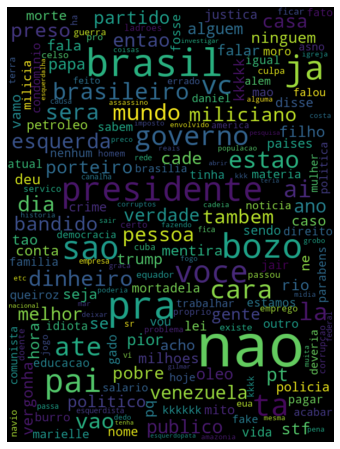

In [98]:
from wordcloud import WordCloud

%matplotlib inline

word_cloud = WordCloud(height=800, width=600, max_font_size=110,
                      collocations=False).generate(todas_palavras)

plt.figure(figsize=(10,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Começa o treino da ML

#### Vai estar separado o treino em base original (em minusculo), base com preprocessamento sem limpeza com unidecode, base com preprocessamento com limpeza de unidecode

In [51]:
### Criar o bagofwords
# base original sem nada
vectorizer = CountVectorizer(analyzer='word', lowercase=False)
bow = vectorizer.fit_transform(comentarios_df['comentario'])

# bow base original
vectorizer_lower = CountVectorizer(analyzer='word', lowercase=False)
bow_lower = vectorizer_lower.fit_transform(comentarios_df['minusculo'])

# bow base original minusculo removendo whitespace
vectorizer_spacelower = CountVectorizer(analyzer='word', lowercase=False)
bow_spacelower = vectorizer_spacelower.fit_transform(comentarios_df['whitespacesnone'])

# bow preprocessamento sem unidecode
vectorizer_su = CountVectorizer(analyzer='word', lowercase=False)
bow_su = vectorizer_su.fit_transform(comentarios_df['comentario_final_su'])

# bow preprocessamento com unidecode
vectorizer_wu = CountVectorizer(analyzer='word', lowercase=False)
bow_wu = vectorizer_wu.fit_transform(comentarios_df['comentario_final_wu'])

In [52]:
### Gerar treino e classe com o train_test_split

# treino e classe base original
treino, teste, classe_treino, classe_teste = train_test_split(bow,
       comentarios_df['toxico'], random_state=42)

# treino e classe base original com letras minusculas 
treino_lower, teste_lower, classe_treino_lower, classe_teste_lower = train_test_split(bow_lower,
       comentarios_df['toxico'], random_state=42)

# treino e classe base com preprocessamento sem unidecode
treino_su, teste_su, classe_treino_su, classe_teste_su = train_test_split(bow_su,
       comentarios_df['toxico'], random_state=42)

# treino e classe base com preprocessamento com unidecode
treino_wu, teste_wu, classe_treino_wu, classe_teste_wu = train_test_split(bow_wu,
       comentarios_df['toxico'], random_state=42)

### Criação dos modelos e treinamento

##### Para cada tipo de modelo foi criado um heatmap de suas matrizes de confusão, gerado precisao e acuracia

#### Primeiro com Regressão Logística

In [68]:
# Base original
classificador = LogisticRegression(solver='lbfgs')
classificador.fit(treino, classe_treino)

previsao = classificador.predict(teste)

acuracia = accuracy_score(classe_teste, previsao)
precisao = precision_score(classe_teste, previsao)

print("Acuracia: %.2f%%" % (acuracia * 100.0), "Precisao: %.2f%%" % (precisao * 100.0))

#report = classification_report(previsao, classe_teste)

#print('report:', report, sep='\n')

Acuracia: 52.72% Precisao: 56.52%


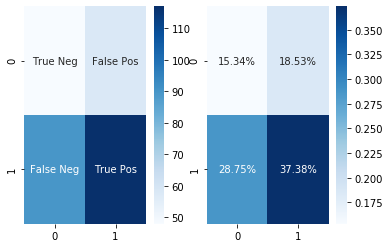

In [73]:
results_classificador = confusion_matrix(previsao, classe_teste) 

labels_classificador = ["True Neg","False Pos","False Neg","True Pos"]
labels_classificador = np.asarray(labels_classificador).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_classificador, annot=labels_classificador, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_classificador/np.sum(results_classificador), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [20]:
# Base original com letras minusculas 
classificador_lower = LogisticRegression(solver='lbfgs')
classificador_lower.fit(treino_lower, classe_treino_lower)

previsao_lower = classificador_lower.predict(teste_lower)

acuracia_lower = accuracy_score(classe_teste_lower, previsao_lower)
precisao_lower = precision_score(classe_teste_lower, previsao_lower)

print("Acuracia: %.2f%%" % (acuracia_lower * 100.0), "Precisao: %.2f%%" % (precisao_lower * 100.0))

Acuracia: 55.59% Precisao: 58.65%


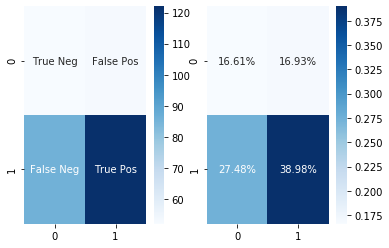

In [72]:
results_classificador_lower = confusion_matrix(previsao_lower, classe_teste_lower) 

labels_classificador_lower = ["True Neg","False Pos","False Neg","True Pos"]
labels_classificador_lower = np.asarray(labels_classificador_lower).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_classificador_lower, annot=labels_classificador_lower, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_classificador_lower/np.sum(results_classificador_lower), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [21]:
# Base com preprocessamento sem unidecode
classificador_su = LogisticRegression(solver='lbfgs')
classificador_su.fit(treino_su, classe_treino_su)

previsao_su = classificador_su.predict(teste_su)

acuracia_su = accuracy_score(classe_teste_su, previsao_su)
precisao_su = precision_score(classe_teste_su, previsao_su)

print("Acuracia: %.2f%%" % (acuracia_su * 100.0), "Precisao: %.2f%%" % (precisao_su * 100.0))

Acuracia: 52.72% Precisao: 56.34%


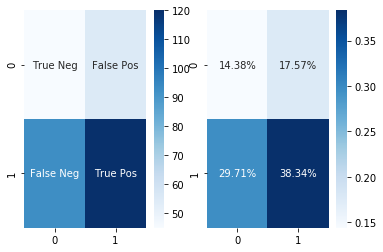

In [71]:
results_classificador_su = confusion_matrix(previsao_su, classe_teste_su) 

labels_classificador_su = ["True Neg","False Pos","False Neg","True Pos"]
labels_classificador_su = np.asarray(labels_classificador_su).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_classificador_su, annot=labels_classificador_su, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_classificador_su/np.sum(results_classificador_su), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [22]:
# Base com preprocessamento com unidecode
classificador_wu = LogisticRegression(solver='lbfgs')
classificador_wu.fit(treino_wu, classe_treino_wu)

previsao_wu = classificador_wu.predict(teste_wu)

acuracia_wu = accuracy_score(classe_teste_wu, previsao_wu)
precisao_wu = precision_score(classe_teste_wu, previsao_wu)

print("Acuracia: %.2f%%" % (acuracia_wu * 100.0), "Precisao: %.2f%%" % (precisao_wu * 100.0))

Acuracia: 51.44% Precisao: 55.40%


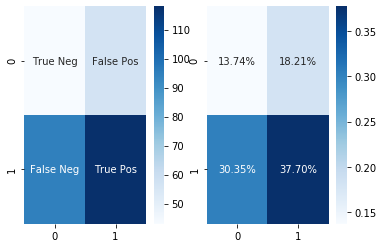

In [70]:
results_classificador_wu = confusion_matrix(previsao_wu, classe_teste_wu) 

labels_classificador_wu = ["True Neg","False Pos","False Neg","True Pos"]
labels_classificador_wu = np.asarray(labels_classificador_wu).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_classificador_wu, annot=labels_classificador_wu, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_classificador_wu/np.sum(results_classificador_wu), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

#### Agora com xgboost

In [23]:
# Base original
model_lower = XGBClassifier()
model_lower.fit(treino_lower, classe_treino_lower)

y_pred_lower = model_lower.predict(teste_lower)
predictions_lower = [round(value) for value in y_pred_lower]

accuracy_lower = accuracy_score(classe_teste_lower, predictions_lower)
precision_lower = precision_score(classe_teste_lower, predictions_lower)

print("Acuracia: %.2f%%" % (accuracy_lower * 100.0), "Precisao: %.2f%%" % (precision_lower * 100.0))

Acuracia: 51.76% Precisao: 55.56%


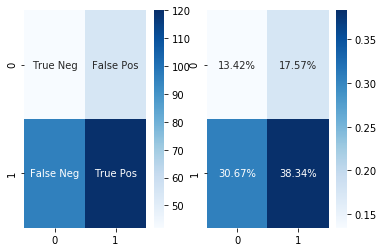

In [46]:
results_model_lower = confusion_matrix(y_pred_lower, classe_teste_lower) 

labels_model_lower = ["True Neg","False Pos","False Neg","True Pos"]
labels_model_lower = np.asarray(labels_model_lower).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_model_lower, annot=labels_model_lower, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_model_lower/np.sum(results_model_lower), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [42]:
# Base com preprocessamento sem unidecode

model_su = XGBClassifier()
model_su.fit(treino_su, classe_treino_su)

y_pred_su = model_su.predict(teste_su)
predictions_su = [round(value) for value in y_pred_su]

accuracy_su = accuracy_score(classe_teste_su, predictions_su)
precision_su = precision_score(classe_teste_su, predictions_su)

print("Acuracia: %.2f%%" % (accuracy_su * 100.0), "Precisao: %.2f%%" % (precision_su * 100.0))

Acuracia: 57.51% Precisao: 58.82%


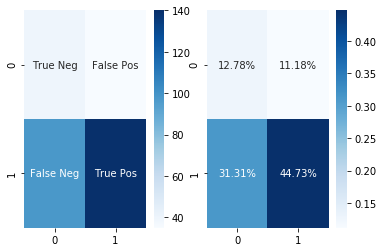

In [43]:
results_model_su = confusion_matrix(y_pred_su, classe_teste_su) 

labels_model_su = ["True Neg","False Pos","False Neg","True Pos"]
labels_model_su = np.asarray(labels_model_su).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_model_su, annot=labels_model_su, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_model_su/np.sum(results_model_su), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [40]:
# Base com preprocessamento com unidecode
model_wu = XGBClassifier()
model_wu.fit(treino_wu, classe_treino_wu)

y_pred_wu = model_wu.predict(teste_wu)
predictions_wu = [round(value) for value in y_pred_wu]

accuracy_wu = accuracy_score(classe_teste_wu, predictions_wu)
precision_wu = precision_score(classe_teste_wu, predictions_wu)

print("Acuracia: %.2f%%" % (accuracy_su * 100.0), "Precisao: %.2f%%" % (precision_wu * 100.0))

Acuracia: 57.51% Precisao: 57.56%


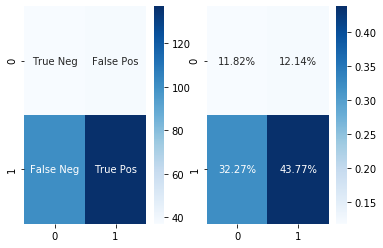

In [44]:
results_model_wu = confusion_matrix(y_pred_wu, classe_teste_wu) 

labels_model_wu = ["True Neg","False Pos","False Neg","True Pos"]
labels_model_wu = np.asarray(labels_model_wu).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_model_wu, annot=labels_model_wu, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_model_wu/np.sum(results_model_wu), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

#### Agora com gradientboosting classifier

In [26]:
# Define possibilidades de valores de aprendizado e identifica qual tras o melhor scrore em acuracia
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate = learning_rate, random_state=42)
    gb.fit(treino_lower, classe_treino_lower)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(treino_lower, classe_treino_lower)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(teste_lower, classe_teste_lower)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.702
Accuracy score (validation): 0.569

Learning rate:  0.1
Accuracy score (training): 0.788
Accuracy score (validation): 0.562

Learning rate:  0.25
Accuracy score (training): 0.915
Accuracy score (validation): 0.527

Learning rate:  0.5
Accuracy score (training): 0.968
Accuracy score (validation): 0.527

Learning rate:  0.75
Accuracy score (training): 0.977
Accuracy score (validation): 0.546

Learning rate:  1
Accuracy score (training): 0.981
Accuracy score (validation): 0.546



In [27]:
# Base original
gb_lower = GradientBoostingClassifier(learning_rate = 0.75, random_state = 42)
gb_lower.fit(treino_lower, classe_treino_lower)
predictions_lower = gb.predict(teste_lower)

accuracy1 = accuracy_score(classe_teste_lower, predictions_lower)
precision1 = precision_score(classe_teste_lower, predictions_lower)
print("Acuracia: %.2f%%" % (accuracy1 * 100.0), "Precisao: %.2f%%" % (precision1 * 100.0))

Acuracia: 54.63% Precisao: 57.75%


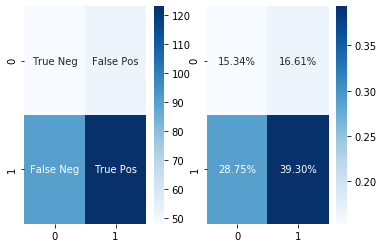

In [28]:
results_gb_lower = confusion_matrix(predictions_lower, classe_teste_lower) 

labels_gb_lower = ["True Neg","False Pos","False Neg","True Pos"]
labels_gb_lower = np.asarray(labels_gb_lower).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_gb_lower, annot=labels_gb_lower, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_gb_lower/np.sum(results_gb_lower), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [29]:
# Base com preprocessamento sem unidecode
gb_su = GradientBoostingClassifier(learning_rate = 0.75, random_state = 42)
gb_su.fit(treino_su, classe_treino_su)
predictions_su = gb_su.predict(teste_su)

accuracy2 = accuracy_score(classe_teste_su, predictions_su)
precision2 = precision_score(classe_teste_su, predictions_su)
print("Acuracia: %.2f%%" % (accuracy2 * 100.0), "Precisao: %.2f%%" % (precision2 * 100.0))

Acuracia: 55.91% Precisao: 57.74%


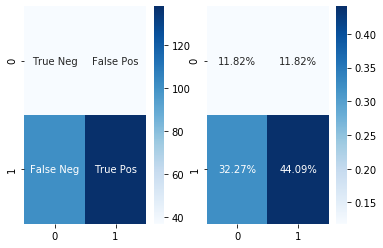

In [30]:
results_gb_su = confusion_matrix(predictions_su, classe_teste_su) 

labels_gb_su = ["True Neg","False Pos","False Neg","True Pos"]
labels_gb_su = np.asarray(labels_gb_su).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_gb_su, annot=labels_gb_su, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_gb_su/np.sum(results_gb_su), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

In [31]:
# Base com preprocessamento com unidecode
gb_wu = GradientBoostingClassifier(learning_rate = 0.75, random_state = 42)
gb_wu.fit(treino_wu, classe_treino_wu)
predictions_wu = gb_wu.predict(teste_wu)

accuracy3 = accuracy_score(classe_teste_wu, predictions_wu)
precision3 = precision_score(classe_teste_wu, predictions_wu)
print("Acuracia: %.2f%%" % (accuracy3 * 100.0), "Precisao: %.2f%%" % (precision3 * 100.0))

Acuracia: 56.55% Precisao: 58.23%


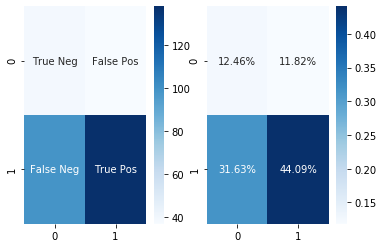

In [38]:
results_gb_wu = confusion_matrix(predictions_wu, classe_teste_wu) 

labels_gb_wu = ["True Neg","False Pos","False Neg","True Pos"]
labels_gb_wu = np.asarray(labels_gb_wu).reshape(2,2)

fig, axs = plt.subplots(ncols=2)

sn.heatmap(results_gb_wu, annot=labels_gb_wu, fmt="", cmap='Blues', ax=axs[0])

sn.heatmap(results_gb_wu/np.sum(results_gb_wu), annot=True, 
            fmt='.2%', cmap='Blues', ax=axs[1])

## Salva os modelos com pickle

In [32]:
joblib.dump(classificador_lower, 'lr_classificador_lower.pkl')
joblib.dump(vectorizer_lower, 'cv_lower.pkl')
print("Modelo regressao logistica lower")
#lr_lower = joblib.load('lr_classificador_lower.pkl')

Modelo regressao logistica lower


In [33]:
model_loaded = open('lr_classificador_lower.pkl', 'rb')
cv_loaded = open('cv_lower.pkl', 'rb')
clf = joblib.load(model_loaded)
cvteste = joblib.load(cv_loaded)

datateste = ['sera possivel que sempre vai dar 1 acho que ta viciado']
vectteste = cvteste.transform(datateste).toarray()
predictteste = clf.predict(vectteste)

print(predictteste)

[0]


In [34]:
joblib.dump(classificador_wu, 'lr_classificador_wu.pkl')
joblib.dump(vectorizer_wu, 'cv_wu.pkl')
print("Modelo regressao logistica wu")
#lr_lower = joblib.load('lr_classificador_lower.pkl')

Modelo regressao logistica wu


In [35]:
model_loaded2 = open('lr_classificador_wu.pkl', 'rb')
cv_loaded2 = open('cv_wu.pkl', 'rb')
clf2 = joblib.load(model_loaded2)
cvteste2 = joblib.load(cv_loaded2)

datateste2 = ['sera possivel que sempre vai dar 1 acho que ta viciado']

#doc2 = nlp(datateste2)
#c2 = ' '.join([token.text for token in doc2 if token.text not in pontuacoes and token.text not in stop_word and not token.text.isdigit()])
    
vectteste2 = cvteste2.transform(datateste2).toarray()
predictteste2 = clf2.predict(vectteste2)

print(predictteste2)

[0]


In [36]:
joblib.dump(classificador_su, 'lr_classificador_su.pkl')
joblib.dump(vectorizer_su, 'cv_su.pkl')
print("Modelo regressao logistica su")
#lr_lower = joblib.load('lr_classificador_lower.pkl')

Modelo regressao logistica su


In [37]:
model_loaded3 = open('lr_classificador_su.pkl', 'rb')
cv_loaded3 = open('cv_su.pkl', 'rb')
clf3 = joblib.load(model_loaded3)
cvteste3 = joblib.load(cv_loaded3)

datateste3 = ['sera possivel que sempre vai dar 1 acho que ta viciado']
vectteste3 = cvteste3.transform(datateste3).toarray()
predictteste3 = clf3.predict(vectteste3)

print(predictteste3)

[1]
